# Imports and setup

In [1]:
# import of necessary libraries
import numpy as np
import pandas as pd
import plotly.express as px

# Definition of functions

In [2]:
def wrangle_phyphox_data(data):
    """
    This function takes a pandas dataframe with phyphox data and returns a
    wrangled pandas dataframe with the following changes:
    - format data to end at the last second
    - interpolate data to 100 Hz

    Parameters
    ----------
    data : pandas dataframe
        pandas dataframe with phyphox data
    """
    # rename columns
    data.columns = ["time", "x", "y", "z", "abs"]

    # set first dataset time to 0
    data["time"] = data["time"] - data["time"][0]

    # get length of dataset in seconds
    length = int(np.max(data["time"]))

    # cutoff everything after last second
    data = data[data["time"] <= length].copy()

    # get interpolated timestamps
    interpolated = np.round(np.linspace(0, length, length * 100), 2)

    # get transformed interpolated timestamps
    interpolated_transformed = pd.to_datetime(interpolated, unit="s")

    # add timestamps for interpolation to dataframe
    data = pd.concat([data, pd.DataFrame({"time": interpolated})], ignore_index=True)

    # convert index to datetime
    data["time"] = pd.to_datetime(data["time"], unit="s")

    # set time as index
    data = data.set_index("time")

    # sort index
    data = data.sort_index()

    # interpolate timestamp using 3rd order polynomial
    data = data.interpolate(method="time", order=3)

    # only keep interpolated timestamps
    data = data[data.index.isin(interpolated_transformed)].copy()

    # remove duplicates
    data = data[~data.index.duplicated(keep="first")]

    # reconvert index to s
    data.index = data.index.astype(np.int64) / 10**9

    # return data
    return data


In [3]:
def plot_movement(data):
    """
    Plot movement of the accelerometer in 3D

    Parameters
    ----------
    data : pandas.DataFrame
        Dataframe containing the data from the accelerometer
    """
    # create figure
    fig = px.line(data, y=["x", "y", "z", "abs"])

    # set labels
    fig.update_layout(
        title="Acceleration Data from all Axes to Time",
        xaxis_title="Time",
        yaxis_title="Acceleration",
        legend_title="Axis",
    )

    # return figure
    return fig


In [4]:
def get_fft(data, axis="x", timespan=(0, np.Inf)):
    """
    Calculates the Fast Fourier Transformation of the given data.
    Returns the frequency spectrum and the plot.

    Parameters
    ----------
    data : pandas.DataFrame
        Dataframe containing the data.
    axis : str
        Axis to calculate the FFT for.
    timespan : tuple
        Tuple containing the start and end time of the timespan (in seconds) to calculate the FFT for.
    """

    # split data with given timespan
    start = timespan[0]
    end = timespan[1]
    data = data[(data.index >= start) & (data.index <= end)]

    # fft of all axis
    fft = np.fft.fft(data[axis])

    # get frequencies
    freq = np.fft.fftfreq(data.shape[0])

    # get absolute values
    fft = np.abs(fft)

    # remove negative frequencies
    fft = fft[freq >= 0]
    freq = freq[freq >= 0]

    # plot frequency spectrum
    fig = px.line(x=freq, y=fft)

    # set labels
    fig.update_layout(
        title=f"Fast Fourier Transformation of Acceleration in {axis}-Axis between {start}s and {end}s",
        xaxis_title="Frequency",
        yaxis_title="Amplitude",
    )

    # return fft values, frequencies and figure
    return fft, freq, fig


# Analysis

## Walking Dataset

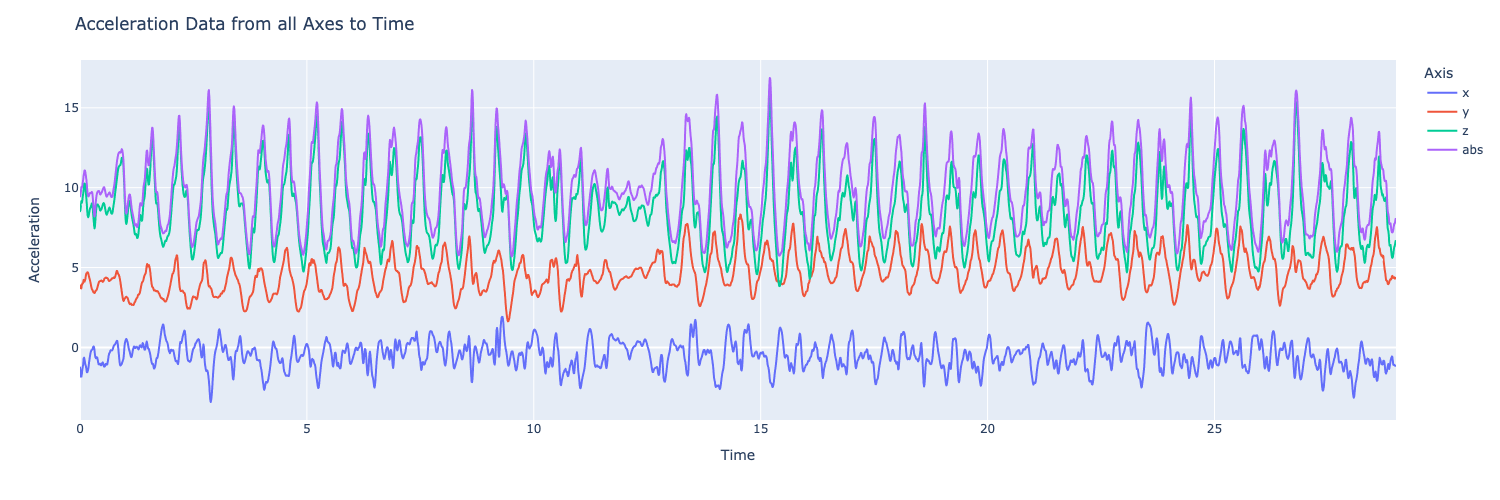

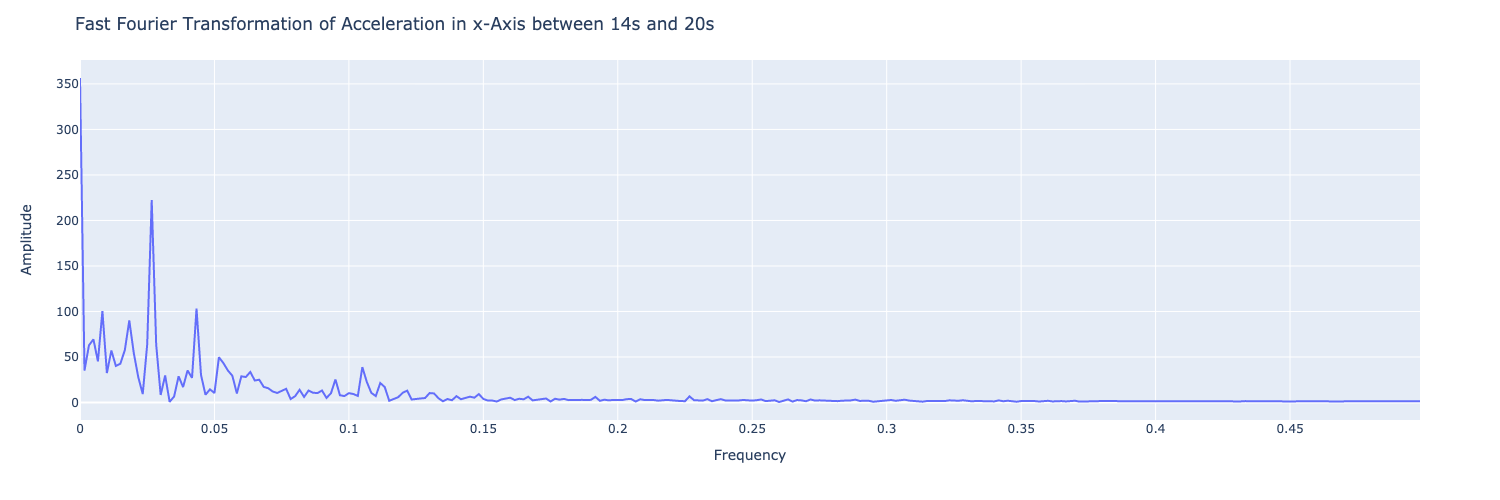

In [5]:
# read data
walking1 = pd.read_csv("Walking1/Raw Data.csv")

# wrangle data
walking1 = wrangle_phyphox_data(walking1)

# plot data
fig = plot_movement(walking1)
fig.show("png", width=1500)

# get fft
_, _, fig = get_fft(walking1, axis="x", timespan=(14, 20))
fig.show("png", width=1500)

## Shaking Dataset

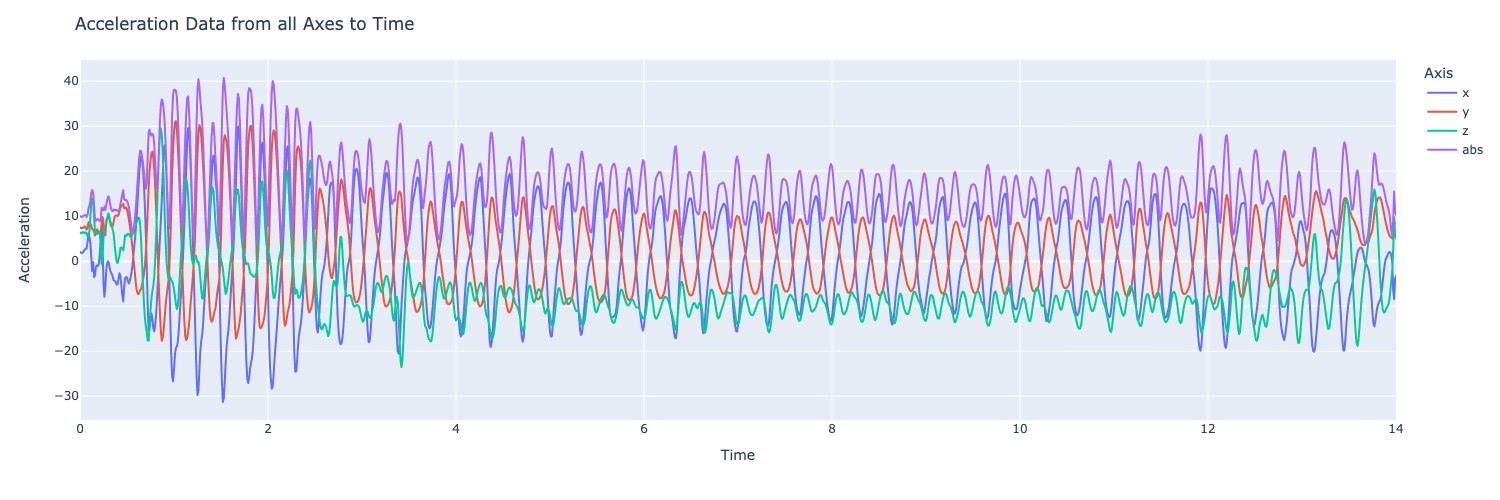

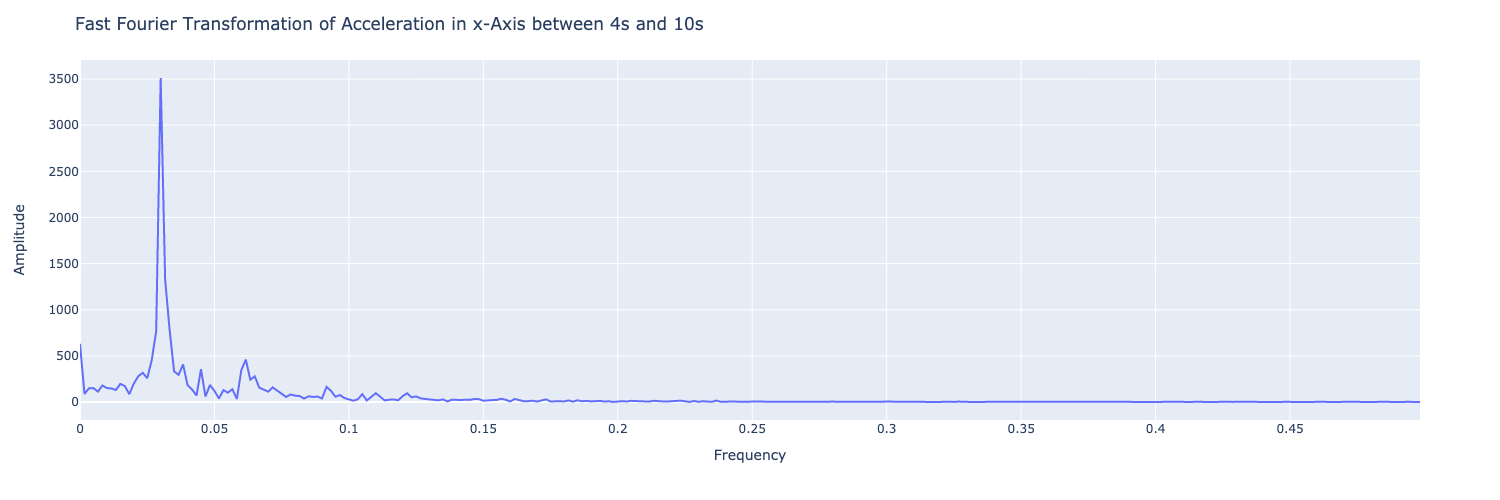

In [6]:
# read data
shaking1 = pd.read_csv("Shaking1/Raw Data.csv")

# wrangle data
shaking1 = wrangle_phyphox_data(shaking1)

# plot data
fig = plot_movement(shaking1)
fig.show("png", width=1500)

# get fft
_, _, fig = get_fft(shaking1, axis="x", timespan=(4, 10))
fig.show("png", width=1500)